In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('dataset/battles_encoded.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      38 non-null     int64  
 1   year                      38 non-null     int64  
 2   attacker_king             38 non-null     int64  
 3   defender_king             38 non-null     int64  
 4   attacker_1                38 non-null     int64  
 5   defender_1                38 non-null     int64  
 6   attacker_outcome          38 non-null     int64  
 7   battle_type               38 non-null     int64  
 8   major_death               37 non-null     float64
 9   major_capture             37 non-null     float64
 10  attacker_size             24 non-null     float64
 11  defender_size             19 non-null     float64
 12  summer                    37 non-null     float64
 13  location                  38 non-null     int64  
 14  region      

In [3]:
df.tail()

,name,year,attacker_king,defender_king,attacker_1,defender_1,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,summer,location,region,attacker_count,defender_count,attacker_commander_count,defender_commander_count
33,29,300,1,4,0,0,1,3,0.0,0.0,NaN,200.0,0.0,22,5,1,1,2,1
34,31,300,1,4,0,0,1,3,0.0,0.0,2000.0,NaN,0.0,4,5,1,1,2,1
35,33,300,1,3,9,10,1,3,0.0,0.0,3000.0,NaN,0.0,15,4,2,1,3,1
36,32,300,1,3,2,1,1,3,0.0,1.0,1500.0,NaN,0.0,13,4,2,1,2,1
37,36,300,4,1,0,2,1,3,NaN,NaN,5000.0,8000.0,0.0,26,2,4,2,1,1


### Impute Missing Values using IterativeImputer & SimpleImputer

[Scikit-learn source code reference](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#imputing-missing-values-with-variants-of-iterativeimputer)

In [4]:
y = df['attacker_outcome']
X = df.drop(columns='attacker_outcome')

In [5]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5
br_estimator = BayesianRidge()

In [6]:
np.random.seed(0)

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [7]:
np.sqrt(38)

6.164414002968976

In [8]:
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=6)
]

score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X, y, scoring='neg_mean_squared_error',
            cv=N_SPLITS
    )

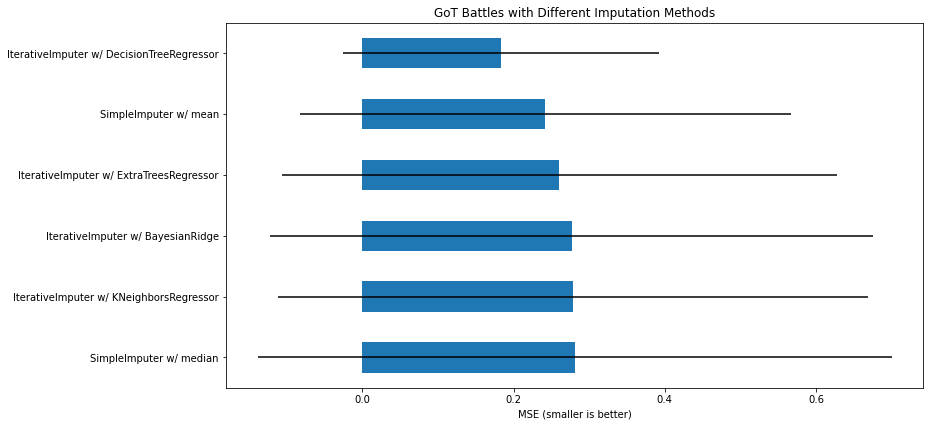

In [9]:
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean().sort_values()
errors = scores.std().sort_values()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('GoT Battles with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [10]:
scores.mean().sort_values(ascending=False)

IterativeImputer  DecisionTreeRegressor   -0.183288
SimpleImputer     mean                    -0.242051
IterativeImputer  ExtraTreesRegressor     -0.260436
                  BayesianRidge           -0.276723
                  KNeighborsRegressor     -0.279171
SimpleImputer     median                  -0.280627
dtype: float64